# PanStarrs catalog inspection

Exploratory notebook for understanding the state of the PanStarrs catalog hosted in Space Telescope open space bucket.

In [53]:
import os
import tempfile
from upath import UPath
import shutil
from hats_import.verification.arguments import VerificationArguments
import hats
from hats_import.pipeline import pipeline
import pandas as pd
import hats
from hats.pixel_math import HealpixPixel
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq


## Verification Pipeline

Everything passes verification tests.

Looking deeper into the verification tests, we explicitly ignore any "hats columns" of (Norder, Dir, Npix). This makes sense because of the way these are added to the pyarrow schema from the hive columns, when loaded as a `ParquetDataset`, but this set up in particular is an unexpected edge case.

In [ ]:
args = VerificationArguments(
    input_catalog_path="s3://stpubdata/panstarrs/ps1/public/hats/otmo/",
    output_path="./output",
)
pipeline(args)

Loading dataset and schema.

Starting: Test hats.io.validation.is_valid_collection.
Validating collection at path s3://stpubdata/panstarrs/ps1/public/hats/otmo ... 
Validating catalog at path s3://stpubdata/panstarrs/ps1/public/hats/otmo/otmo ... 
Found 27161 partitions.
Approximate coverage is 76.03 % of the sky.
Validating catalog at path s3://stpubdata/panstarrs/ps1/public/hats/otmo/otmo_10arcs ... 
Found 27297 partitions.
Approximate coverage is 87.50 % of the sky.
Validating catalog at path s3://stpubdata/panstarrs/ps1/public/hats/otmo/otmo_objID ... 
Result: PASSED

Starting: Test that files in _metadata match the data files on disk.
Result: PASSED

Starting: Test that number of rows are equal.
	file footers vs catalog properties
	file footers vs _metadata
Result: PASSED

Starting: Test that schemas are equal, excluding metadata.
	_common_metadata vs truth
	_metadata vs truth
	file footers vs truth
Result: PASSED

Verifier results written to output/verifier_results.csv
Elapsed ti

## Manual inspection

The catalog root directory doesn't contain a `hats.properties` file, only the `properties` file. The `properties` file will be depcrecated in the next published version of the note, and was replaced by `hats.properties` in summer 2025.

In [3]:
otmo_dir = UPath("s3://stpubdata/panstarrs/ps1/public/hats/otmo/otmo", anon=True)
otmo_dir.exists()

True

In [4]:
for item in otmo_dir.iterdir():
    print(item)

s3://stpubdata/panstarrs/ps1/public/hats/otmo/otmo/dataset
s3://stpubdata/panstarrs/ps1/public/hats/otmo/otmo/partition_info.csv
s3://stpubdata/panstarrs/ps1/public/hats/otmo/otmo/point_map.fits
s3://stpubdata/panstarrs/ps1/public/hats/otmo/otmo/properties


## File Size Inspection

Duplicate of this demo notebook:

https://hats.readthedocs.io/en/latest/notebooks/catalog_size_inspection.html

In [3]:
catalog_dir = UPath("s3://stpubdata/panstarrs/ps1/public/hats/otmo/otmo", anon=True)

catalog = hats.read_hats(catalog_dir)
info_frame = pd.read_csv("./output/otmo_file_sizes.csv")
# info_frame = catalog.partition_info.as_dataframe()

# for index, partition in tqdm(info_frame.iterrows()):
#     file_name = result = hats.io.paths.pixel_catalog_file(
#         catalog_dir, HealpixPixel(partition["Norder"], partition["Npix"])
#     )
#     info_frame.loc[index, "size_on_disk"] = file_name.stat().st_size

# info_frame = info_frame.astype(int)
# info_frame["gbs"] = info_frame["size_on_disk"] / (1024 * 1024 * 1024)
# info_frame.to_csv("./output/otmo_file_sizes.csv")

In [9]:
print(f'healpix orders: {info_frame["Norder"].unique()}')
print(f'num partitions: {len(info_frame["Npix"])}')
print("------")
print(f'min size_on_disk: {info_frame["gbs"].min():.2f}')
print(f'max size_on_disk: {info_frame["gbs"].max():.2f}')
print(f'size_on_disk ratio: {info_frame["gbs"].max()/info_frame["gbs"].min():.2f}')
print(f'total size_on_disk: {info_frame["gbs"].sum():.2f}')

healpix orders: [2 5 6 7]
num partitions: 27161
------
min size_on_disk: 0.01
max size_on_disk: 0.38
size_on_disk ratio: 40.69
total size_on_disk: 2781.25


small-ish 	: 27161 	(100.0 %)
sweet-spot 	: 0 	(0.0 %)
big-ish 	: 0 	(0.0 %)
too-big 	: 0 	(0.0 %)


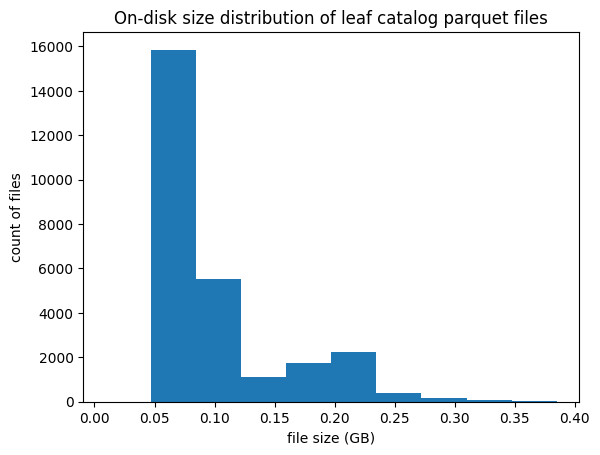

In [ ]:

plt.hist(info_frame["gbs"])
plt.ylabel("count of files")
plt.xlabel("file size (GB)")
plt.title("On-disk size distribution of leaf catalog parquet files")
bins = [0, 0.5, 1, 2, 100]
labels = ["small-ish", "sweet-spot", "big-ish", "too-big"]
hist = np.histogram(info_frame["gbs"], bins=bins)[0]
pcts = hist / len(info_frame)
for i in range(0, len(labels)):
    print(f"{labels[i]} \t: {hist[i]} \t({pcts[i]*100:.1f} %)")

## Pixel threshold estimation

Duplicate of this demo notebook:

https://hats-import.readthedocs.io/en/latest/notebooks/estimate_pixel_threshold.html

But using what we already know from the above steps, and using the largest parquet file (for potentially the most demonstrative compression/overhead).

Looks like it was originally imported with `1000000` as the limit, but `2_500_000` would be good.

However, the files have been written with `'SNAPPY'` compression, which isn't as efficient for most astronomy data as the `'ZSTD'` compression the hats-import pipeline uses by default. The numbers will be a little off (but not enough to panic about).

In [13]:
info_frame.sort_values('gbs').tail(1)

,Norder,Npix,size_on_disk,gbs
20690,6,28797,413226729,0.384847


In [ ]:


sample_parquet_file = UPath("s3://stpubdata/panstarrs/ps1/public/hats/otmo/otmo/dataset/Norder=6/Dir=20000/Npix=28797.parquet", anon=True)
pq_file = pq.ParquetFile(sample_parquet_file.path, filesystem=sample_parquet_file.fs)

sample_file_size = 413226729
# parquet_file = pq.ParquetFile(sample_parquet_file)
num_rows = pq_file.metadata.num_rows

## 300MB
ideal_file_small = 300 * 1024 * 1024
## 1G
ideal_file_large = 1024 * 1024 * 1024

threshold_small = ideal_file_small / sample_file_size * num_rows
threshold_large = ideal_file_large / sample_file_size * num_rows

print(f"threshold between {int(threshold_small):_} and {int(threshold_large):_}")

threshold between 745_603 and 2_544_993


In [ ]:
pq_file.metadata.row_group(0).column(0).compression

'SNAPPY'

In [8]:
pq_file.metadata

  created_by: parquet-cpp-arrow version 18.1.0
  num_columns: 135
  num_rows: 979434
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 27919

## Consider default columns

There are no default columns specified in the properties, and, well, by default users will be loading all 135 columns in the dataset. These are likely not very useful to all users, and so can be reduced.

Data sizes during typical use (using the 30 "core fields" identified below) would drop around 75%, if these are set as default columns.

This is accomplished with the `addl_hats_properties` argument. While we're at it, we can set the observation regime to optical.

```
addl_hats_properties={"hats_cols_default": "decMean,decMeanErr,epochMean,gFlags,gMeanPSFMag,gMeanPSFMagErr,iFlags,iMeanPSFMag,iMeanPSFMagErr,nDetections,ng,ni,nr,ny,nz,objID,objInfoFlag,qualityFlag,raMean,raMeanErr,rFlags,rMeanPSFMag,rMeanPSFMagErr,surveyID,yFlags,yMeanPSFMag,yMeanPSFMagErr,zFlags,zMeanPSFMag,zMeanPSFMagErr", "obs_regime": "Optical"}
```

In [16]:
catalog.catalog_info.model_dump(by_alias=False, exclude_none=True)

{'catalog_name': 'otmo',
 'catalog_type': 'object',
 'total_rows': 10560724292,
 'ra_column': 'raMean',
 'dec_column': 'decMean',
 'npix_suffix': '.parquet',
 'hats_builder': 'hipscat_import v0.2.5 hats-importer conversion v0.4.3',
 'hats_creation_date': '2024-12-11T19:35UTC',
 'hats_estsize': '2916861370',
 'hats_release_date': '2024-09-18',
 'hats_version': 'v0.1',
 'hats_cols_sort': 'objID',
 'hats_cols_survey_id': 'objID',
 'hats_max_rows': '1000000',
 'hats_order': '7'}

In [4]:
all_stats = catalog.per_pixel_statistics(multi_index=True)
all_stats.to_csv("./output/otmo_per_pixel_statistics_multi_index.csv")

In [47]:
stats_swap = all_stats.swaplevel('column', "pixel")
stats_swap = stats_swap.sort_index()
disk_bytes = stats_swap['disk_bytes'].astype(int)
sizes = disk_bytes.groupby(level=0).sum()
sizes

column
astrometryCorrectionFlag     1610668047
b                           92022380725
                               ...     
zQfPerfect                  20805315067
zoneID                       3120953323
Name: disk_bytes, Length: 131, dtype: int64

In [48]:
percents = [f"{s/sizes.sum()*100:.1f}" for s in sizes]
nice_sizes = pd.DataFrame({"size": sizes.astype(int), "percent": percents}).sort_values(
    "size", ascending=False
)
nice_sizes

,size,percent
column,,
objNameHMS,95069086226,3.3
randomID,92550727840,3.2
...,...,...
objAltName1,2009914,0.0
objAltName2,2009914,0.0


In [ ]:
core_fields = """decMean
decMeanErr
epochMean
gFlags
gMeanPSFMag
gMeanPSFMagErr
iFlags
iMeanPSFMag
iMeanPSFMagErr
nDetections
ng
ni
nr
ny
nz
objID
objInfoFlag
qualityFlag
raMean
raMeanErr
rFlags
rMeanPSFMag
rMeanPSFMagErr
surveyID
yFlags
yMeanPSFMag
yMeanPSFMagErr
zFlags
zMeanPSFMag
zMeanPSFMagErr""".split("\n")

In [ ]:
## Ratio of compressed on-disk usage of just-the-core-fields to all-the-fields
## == 23.8%

nice_sizes.loc[core_fields].sum()['size'] / nice_sizes.sum()['size']

np.float64(0.23810543011402724)